In [1]:
import numpy as np

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.extensions import Initialize
from qiskit.quantum_info import random_statevector
from qiskit.tools import job_monitor

#Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

## Teleportation Protocol

In this notebook, we will demonstrate the teleportation protocol between a bi-partite system with the use of multi-qubit gates (quantum circuit). Those parts will be called Alice (part A) and Bob (part B). For this purpose, we build a so called '<i> Bell Measurement </i>', which means we project a state onto the four Bell states:

$$
|\psi^{00}\rangle=\frac{1}{2}(|00\rangle + |11\rangle)
$$

$$
|\psi^{01}\rangle=\frac{1}{2}(|00\rangle - |11\rangle)
$$

$$
|\psi^{10}\rangle=\frac{1}{2}(|10\rangle + |01\rangle)
$$

$$
|\psi^{11}\rangle=\frac{1}{2}(|10\rangle - |01\rangle)
$$

Here, Bob wants to send his quantum state $\phi$ to Alice. The problem however is that Alice and Bob only share a classical channel (e.g. a phone) and a Bell state (for instance, $|\psi^{00}\rangle$ ). We will see that with this common Bell state created by a third part and shared with Alice and Bob, Bob's desire in sharing the qubit with Alice by teleportation is possible. It is important to emphasize that by teleportation we mean a quantum information will be sending for one part to the other without any local operation.

<div class="alert alert-block alert-success">

<b>Part 1</b>
    
First, we will generate the Bell state: $|\psi^{00}\rangle$ between qubit $q_0$ and $q_1$.
    
</div>

In [2]:
def psi_00(circuit, q1, q2):
    circuit.h(q1)
    circuit.cx(q1, q2)  

<div class="alert alert-block alert-success">

<b>Part 2</b>
    
Here, we will read out $q_1$ and $q_2$ in the Bell basis.</b> (This means that we want to obtain $xz$ from $|\psi^{xz}\rangle$ ). For this purpose, we store the outcomes in the classical registers $z \rightarrow$ `crz` and $x \rightarrow$`crx`.    

</div>

In [3]:
def Bell_measurement(circuit, q1, q2, crx, crz):
    circuit.cx(q2, q1)
    circuit.h(q2)
    circuit.barrier()
    circuit.measure(q1,crx)
    circuit.measure(q2,crz)

<div class="alert alert-block alert-success">

<b>Part 3 </b>
    
Now Bob sends his found $xz$ to Alice. She, on her turn applies to following conditional gates on here qubit $q_0$: $X^xZ^z$
    
</div>

In [4]:
def conditional_gates(circuit, q0, crx, crz):
    circuit.x(q0).c_if(crx, 1)
    circuit.z(q0).c_if(crz, 1)

### Circuit

Now, let's buid the circuit. For now on, we consider $qAlice$ to be Alice's qubit, which is entangled with $qBob$  on Bob's side. The state we want to teleport is encoded on $qE$. First, visualize the state that Bob initially has (we will initialize a random state for the Bob's qubit)

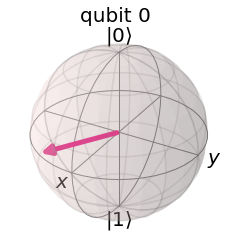

In [5]:
psi = random_statevector(2)
init_gate = Initialize(psi)
init_gate.label = "Bob's state"

plot_bloch_multivector(psi)

Now, we bring the circuit together:

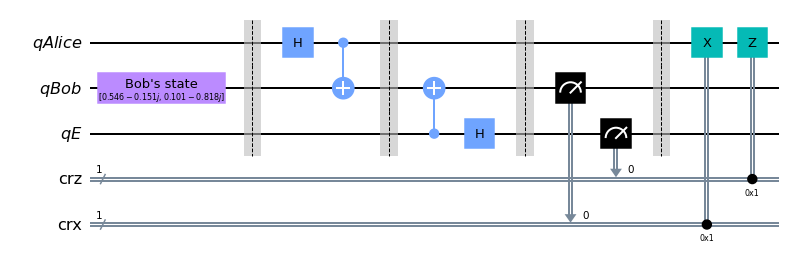

In [6]:
qA = QuantumRegister(1, name="qAlice")  # Alice's qubit
qB = QuantumRegister(1, name="qBob")    # Bob's qubit
qe = QuantumRegister(1, name="qE")      # qubit exchanged

crz = ClassicalRegister(1, name="crz")  # and 2 classical bits
crx = ClassicalRegister(1, name="crx") 
teleportation_circuit = QuantumCircuit(qA, qB, qe, crz, crx)

# random state for Bob
teleportation_circuit.append(init_gate, [1])
teleportation_circuit.barrier()

#Part 1:  Create the Bell state between q0 and q1
psi_00(teleportation_circuit, 0,1 )

#Part 2: Bell Measurement
teleportation_circuit.barrier()
Bell_measurement(teleportation_circuit, 1,2, crx, crz)

#Part 3: Conditional Gates
teleportation_circuit.barrier()
conditional_gates(teleportation_circuit, 0, crx, crz)

teleportation_circuit.draw('mpl')

In [7]:
sim = Aer.get_backend('aer_simulator')
teleportation_circuit.save_statevector()

out_vector = sim.run(teleportation_circuit).result().get_statevector()
out_vector.draw('latex')

<IPython.core.display.Latex object>

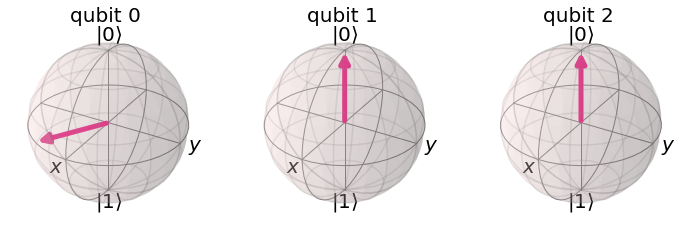

In [8]:
plot_bloch_multivector(out_vector)

Note, Alice (in this case qubit 0) has the very state Bob used to have. Congrats! you perfomed sucessfully the teleportation protocol. 

## Teleportation in a _real_ computer

In addition, note also that without the measurements made earlier we won't be able teleport a qubit state without a direct quantum communication channel. However, IBM quantum computers do not support any further commands after measurements. This does not limit our ability to perform any calculation due to the principle of deferred measurement though. It states that any measurement can be deferred until the end of the circuit. In this case we achieve that by replacing `measure(0,2) + z-Gate(0)`$\to$ `cz-Gate(0,2)` and `measure(1,2) + x-Gate(0)`$\to$ `cx-Gate(0,1)`

For further infos check on: 

[1] M. Nielsen and I. Chuang, Quantum Computation and Quantum Information, Cambridge Series on Information and the Natural Sciences (Cambridge University Press, Cambridge, 2000) (chapter 4.4).

[2] [Qiskit textbook](https://qiskit.org/textbook/ch-algorithms/teleportation.html)

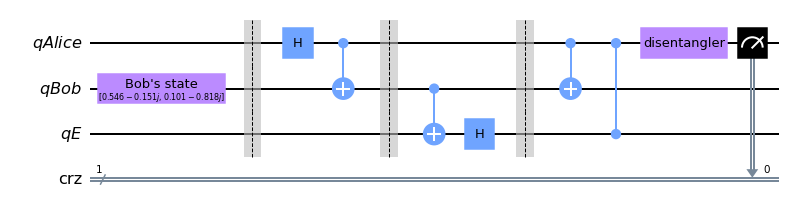

In [9]:
teleportation_circuit1 = QuantumCircuit(qA, qB, qe, crz)

# Again, the same random state is appied to Bob
teleportation_circuit1.append(init_gate, [1])
teleportation_circuit1.barrier()

# Part 1 and 2 without performing measurement
psi_00(teleportation_circuit1, 0,1 )
teleportation_circuit1.barrier()
teleportation_circuit1.cx(1, 2)
teleportation_circuit1.h(2)

#Applying the cz and cx instead of Bell measurements and conditional gates
teleportation_circuit1.barrier()
teleportation_circuit1.cx(0,1)
teleportation_circuit1.cz(0,2)

#To make the visualization easier we apply a disentangler
#it brings the random \psi to |0>.
inverse_init_gate = init_gate.gates_to_uncompute()
teleportation_circuit1.append(inverse_init_gate, [0])

#Finally measuring it
teleportation_circuit1.measure(0,0)

teleportation_circuit1.draw('mpl')

Let us check the availability of IBM's quantum computers

In [10]:
%qiskit_backend_overview

Now, since we have picked one of the real computers, we will run the circuit and get the respective probabilities

In [12]:
backend = provider.get_backend('ibm_nairobi')
#backend = Aer.get_backend('qasm_simulator')

job = execute(teleportation_circuit1, backend = backend)
job_monitor(job)

Job Status: job has successfully run


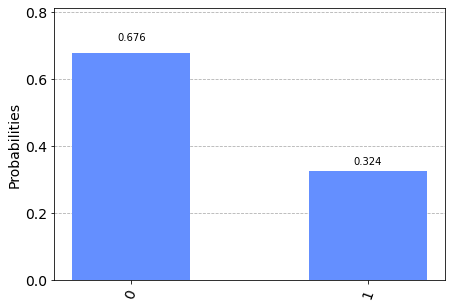

In [13]:
results = job.result()
counts = results.get_counts()

plot_histogram(counts)

So, the probability of measuring $|0\rangle$ is much greater than the probability of $|1\rangle$. Nevertheless, the occurrence of $|1\rangle$ is not zero. This happens due to errors in the gates and the qubits. 